# 2D species transport (Part I): Determination of filter velocity to be used in advection term

We will use the advection-diffusion equation (Eq. 1) for realisation of species transport in our modelling domain (Fig. 1). Implementation of the simplified 2D formulation (without source/sink term, cf. Eqs. 2 and 3) is undertaken in multiple steps and first requires the calculation of the two components of the filter velocity (Darcy velocity) $q_x$ and $q_y$ at each grid node.

$\frac{\partial C}{\partial t} = \underbrace{\nabla \cdot (\mathbf{D}  \nabla C)}_{\text{Diffusion}} \underbrace{- \nabla \cdot (\mathbf{q} C)}_{\text{Advection}}$ (Equation 1)

$\frac{\partial C}{\partial t} = \underbrace{\mathbf{D} \nabla^2 C}_{\text{Diffusion}} \underbrace{- \nabla \cdot (\mathbf{q} C)}_{\text{Advection}}$ (Equation 2)

$\frac{\partial C}{\partial t} = \underbrace{\mathbf{D} \left[ \frac{\partial ^2C}{\partial x^2} +\frac{\partial ^2C}{\partial y^2} \right]}_{\text{Diffusion}} \underbrace{- q_x \frac{\partial C}{\partial x} - q_y \frac{\partial C}{\partial y}  }_{\text{Advection}}$ (Equation 3)

Hereby, $D$ represents the dispersion coefficient (we have discussed this term in detail in the lecture before) and $C$ stands for the species concentration (alternatively, another quantity may be transported, e.g., mass, temperature or energy). Eq. 3 consists of a 2D diffusion term and a 2D advection term, whereby we assume an isotropic and homogeneous spatial distribution of D (assumption made in Eq. 2). The filter velocity $\mathbf{q}$ is a component of the advection term and will be investigated today in detail, since its correct implementation in our source code is required to allow for the validation of our species transport model.

<img src="09-GW_Modell_Velocity1.png" style="width:500px"/> 
**Figure 1**: Geometry and boundary conditions of the initial groundwater flow model . All units given in $m$ (not to scale).

Today's **learning objectives** are:
-  Derivation of filter velocity from hydraulic heads
-  Validiation of implemented model by means of pre-defined boundary condition
-  Extension of pumping well model by two further injection wells
-  Graphical representation of filter velocity by means of vectors and stream lines

**The *validated 2D groundwater flow model* implemented last week addressing the Theis problem (please use the model developed last week as starting point) will serve as basis for the following exercises.**

## Model parameters
-  Storativity $S = 0.0002$
-  Transmissivity $T = 1{,}000\,m^2/day$
-  Simulation time $t = 0.00175\,days$
-  Initial hydraulic head and aquifer thickness $h = b = 20\,m$
-  Pumping rate $Q = 1{,}000\,m^3/day$

### Exercises
1. Please extend the existing model by the calculation of the filter velocity $\mathbf{q}$. At which location in the source code should $q_x$ and $q_y$ be calculated?
2. Adapt the model to the boudnary conditions given in Fig. 1.
3. Run the simulation and visualise the two components of $\mathbf{q}$ individually. Extend the simulation time, so that a steady state is achieved.
4. Which values of $q_x$ and $q_y$ should a valid model exhibit?
5. Duplicate your model cell and change the model dimensions and boundary conditions in the duplicated cell as given in Fig. 2. The cumulative flow rate in both injection wells is $Q$ and that in the production well is $Q$. Run the simulation and visualise both components of the filter velocity ($q_x$ and $q_y$).
6. Visualise the filter velocity by means of vectors (*quiver* plot function) and stream lines (*streamplot* plot function).

    <img src="09-GW_Modell_Velocity2.png" style="width:500px"/> 
    **Figure 2**: Geometry and boundary conditions of the extended groundwater flow model. All units given in $m$ (not to scale).




dt 9.719878501518732 nt 17778


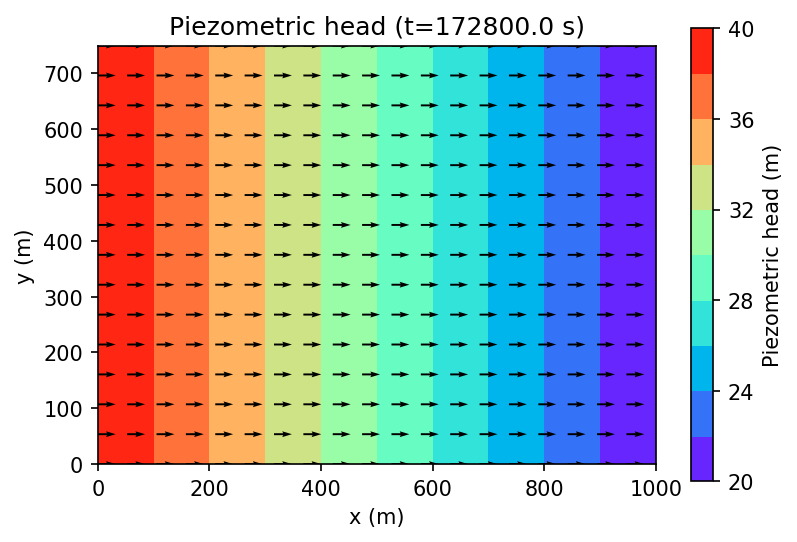

In [5]:
'''
    Numerical solution of groundwater flow equation on finite 2D surface
   
    Parameters:
    lx : Model length in x-direction (m)
    ly : Model length in y-direction (m)
    nx : Number of nodes in x-direction (-)
    ny : Number of nodes in y-direction (-)
    dx : Distance between nodes in x-direction (m)
    dy : Distance between nodes in y-direction (m)
    nt : Number of time steps (-)
    dt : Time step size (s)
    Q  : Pumping rate (m^3/s)
    r  : Radial distance to pumping well (m)
    t  : Time (s)
    hm : Thickness of groundwater aquifer (m)
    T  : Transmissivity of groundwater aquifer (m^2/s)
    alpha: Hydraulic diffusivity (m^2/s)
    t  : Simulation time (s)
    h  : numpy matrix (array) with nx x ny elements of value 0
         Results of time step n+1 (m)
    qx : numpy matrix (array) with nx x ny elements of value 0
    qy : numpy matrix (array) with nx x ny elements of value 0
    hn : numpy matrix with results of time step n (m)
    B  : numpy matrix for assignment of bounday conditions (-)
'''

# Load required libraries
import numpy
from matplotlib import pyplot, cm
%matplotlib inline

# Model parametrisation 
lx = 1000             # Model length in x-direction (m)
ly = 750              # Model length in x-direction (m)
nx = 21               # Number of nodes in x-direction (-)
ny = 16               # Number of nodes in y-direction (-)
dx = lx / (nx - 1)    # Distance between nodes in x-direction (m)
dy = ly / (ny - 1)    # Distance between nodes in y-direction (m)
Q = 1000/86400
T = 1000/86400 # kf = T / hm
S = 0.0002
alpha = T/S           # Hydraulic Diffusivity (m^2/s)
h_ini = 20            # Initial piezometric head (m)
K = T / h_ini         # Hydraulic conductivity (m/s)
t = 0.00175*86400     # Simulation time (s)
t = 2*86400     # Simulation time (s)
dt = 1/(2*alpha*(1/dx**2+1/dy**2))*0.9 # Integer dt calculated based on 
                                       # Neumann convergence criterion
# Time step adaptation (simple scheme)
nt = int(numpy.ceil(t/dt))        
dt = t/nt
print('dt', dt, 'nt', nt) # Print out for verification (can be commented out)

# Initialise matrices for calculation
h = numpy.ones((nx,ny))*h_ini   # numpy matrix (array) with nx x ny elements
                                # of value 
                                # Results for time step (n+1)
qx = numpy.zeros((nx-1,ny-1))    # Darcy flux in x and y directions
qy = numpy.zeros((nx-1,ny-1))

hn = numpy.ones((nx,ny))   # numpy matrix with results for time step n

B = numpy.zeros((nx,ny))   # B = 0 : no b.c.
                           # B = 1 : Neumann flow b.c. (production well)
                           # B = 2 : no b.c., marker for observation well
        
# t_n = numpy.zeros((nt+1))                  # Vector to store simulation time for
#                                          # comparison against Theis method
# Numerical = numpy.ones((nt+1))*h_ini            # Numerical piezometric heads
# Analytical = numpy.ones((nt+1))*h_ini           # Analytical piezometric heads

# Initial conditions will be applied by means of analytical solution
# for simulation time t = 0
# B[int(nx/2),int(ny/2)] = 1 # Pumping well location (model centre)
                          # well (model centre +
                          # 100 m in x-direction)

# # Injection well upper right corner
# B[int(nx/2)+int(numpy.round(100/dx,0)),int(ny/2)+int(numpy.round(100/dy,0))] = 2 
# # Injection well lower right corner
# B[int(nx/2)+int(numpy.round(100/dx,0)),int(ny/2)-int(numpy.round(100/dy,0))] = 2
# # Injection well upper left corner
# B[int(nx/2)-int(numpy.round(100/dx,0)),int(ny/2)+int(numpy.round(100/dy,0))] = 2 
# # Injection well lower left corner
# B[int(nx/2)-int(numpy.round(100/dx,0)),int(ny/2)-int(numpy.round(100/dy,0))] = 2


# FDM formulation of 2D PDE
for n in range(1,nt+1):  # Iterate over number of time steps nt
    hn = h.copy()    # Copy head h of previous time step t into hn
    for i in range(0, nx - 1): # Iterate over nodes in i-direction
                               # omitting first and last node (Dirichlet b.c.)
        for j in range(0, ny): # Iterate over nodes in j-direction
            if i == 0: # Neumann - flow b.c. at left boundary
                # x-direction PDE term
                h[i,j] = hn[i,j] + \
                    alpha * dt / dx**2 * \
                    (hn[i+1,j] - hn[i,j]) \
                    + Q*dt/(dx * dy * S) # Inflow at left b.c.
                if j == 0: # y-direction PDE term for lower left corner
                    h[i,j] += alpha * dt / dy**2 * \
                        (hn[i,j+1] - hn[i,j])
                elif j == ny-1: # y-direction PDE term for upper left corner
                    h[i,j] += alpha * dt / dy**2 * \
                        (hn[i,j-1] - hn[i,j])
                else: # y-direction PDE term for any node in between
                    h[i,j] += alpha * dt / dy**2 * \
                        (hn[i,j+1] - 2 * hn[i,j] + hn[i,j-1])
            elif j == 0: # Neumann - no flow b.c. at bottom boundary
                h[i,j] = hn[i,j] + \
                    alpha * dt / dx**2 * \
                    (hn[i+1,j] - 2 * hn[i,j] + hn[i-1,j]) + \
                    alpha * dt / dy**2 * (hn[i,j+1] - hn[i,j]) 
            elif j == ny-1: # Neumann - no flow b.c. at top boundary
                h[i,j] = hn[i,j] + \
                    alpha * dt / dx**2 * \
                    (hn[i+1,j] - 2 * hn[i,j] + hn[i-1,j]) + \
                    alpha * dt / dy**2 * (hn[i,j-1] - hn[i,j]) 
            else: # all other elements
                h[i,j] = hn[i,j] + \
                    alpha * dt / dx**2 * \
                    (hn[i+1,j] - 2 * hn[i,j] + hn[i-1,j]) + \
                    alpha * dt / dy**2 * \
                    (hn[i,j+1] - 2 * hn[i,j] + hn[i,j-1])
                # if B[i,j] == 1: # Integrate source term into FDM formulation
                #                 # W = Q/(dx*dy*dz) and S_s = S * b and b = dz
                #                 # --> W = Q*dt/(S*dx*dy)
                #                 # Sink: negative sign
                #     h[i,j] = h[i,j] - 4 * Q * dt/(S*dx*dy)
                # elif B[i,j] == 2: # Observation OR injection well (Exercise 6)
                #     h[i,j] = h[i,j] + Q * dt/(S*dx*dy)
                    # t_n[n] = n*dt # time series
                    # Numerical[n] = h[i,j] # Numerical piezometric head
                    # # Piezometric head analytical solution one time step in 
                    # # advance, since first numerical time step 
                    # # n = 0 -> n * dt = 0
                    # # SOLUTION to this: iterate time over range(1,nt+1) 
                    # Analytical[n] = h_ini- \
                    #    Theis(numpy.round(100/dx,0)*dx, n*dt, Q, S, T)
                    # # # W = Q/(dx*dy*dz) und S_s = S * b and b = dz
                    # # # --> W = Q*dt/(S*dx*dy)
                    # # Sink: negative sign
                    # #h[i,j] = h[i,j] + Q/S * dt/(dx*dy)i
                    
    # calculation of Darcy velocities from hydraulic heads at time step n
    for i in range(0,nx-1):
        for j in range(0,ny-1):
            qx[i,j] = -K * (h[i+1,j] - h[i,j]) / dx
            qy[i,j] = -K * (h[i,j+1] - h[i,j]) / dy
        
# Graphical representation of results
x = numpy.linspace(0, lx, nx-1)
y = numpy.linspace(0, ly, ny-1)
xh = numpy.linspace(0, lx, nx)
yh = numpy.linspace(0, ly, ny)

# 2D contour plot of results
fig = pyplot.figure(dpi=150)
ax = fig.gca(aspect=1)
X, Y = numpy.meshgrid(x, y)
Xh, Yh = numpy.meshgrid(xh, yh)
nux = ax.contourf(Xh, Yh, numpy.transpose(h), 10, cmap=cm.rainbow,
        alpha=1, antialiased=True, linestyles='solid');
cbnux = fig.colorbar(nux);
cbnux.set_label('Piezometric head (m)')
pyplot.title('Piezometric head (t='+str(numpy.round(nt*dt,2))+' s)');
ax.set_xlabel('x (m)');
ax.set_ylabel('y (m)');
nux2 = ax.quiver(X, Y, numpy.transpose(qx), numpy.transpose(qy));

# # Cross section along y = 1 m 
# fig2 = pyplot.figure(dpi=150)    
# pyplot.plot(t_n,Analytical, label='Analytical')
# pyplot.plot(t_n,Numerical, label='Numerical',linestyle='--')
# pyplot.title('Development of piezometric head after Theis');
# pyplot.xlabel('Time (s)');
# pyplot.ylabel('Piezometric head (m)');
# fig2.legend(loc=4);
# %timeit

In [6]:
qx[:,1]

array([1.15740741e-05, 1.15740741e-05, 1.15740741e-05, 1.15740741e-05,
       1.15740741e-05, 1.15740741e-05, 1.15740741e-05, 1.15740741e-05,
       1.15740741e-05, 1.15740741e-05, 1.15740741e-05, 1.15740741e-05,
       1.15740741e-05, 1.15740741e-05, 1.15740741e-05, 1.15740741e-05,
       1.15740741e-05, 1.15740741e-05, 1.15740741e-05, 1.15740741e-05])

In [7]:
Q/dy/h_ini

1.1574074074074073e-05

dt 1.542857142857143 nt 98


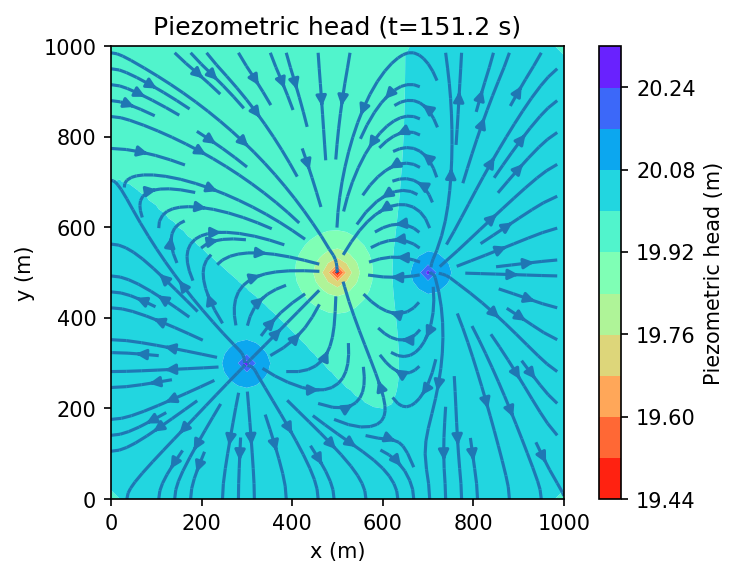

In [14]:
'''
    Numerical solution of groundwater flow equation on finite 2D surface
   
    Parameters:
    lx : Model length in x-direction (m)
    ly : Model length in y-direction (m)
    nx : Number of nodes in x-direction (-)
    ny : Number of nodes in y-direction (-)
    dx : Distance between nodes in x-direction (m)
    dy : Distance between nodes in y-direction (m)
    nt : Number of time steps (-)
    dt : Time step size (s)
    Q  : Pumping rate (m^3/s)
    r  : Radial distance to pumping well (m)
    t  : Time (s)
    hm : Thickness of groundwater aquifer (m)
    T  : Transmissivity of groundwater aquifer (m^2/s)
    alpha: Hydraulic diffusivity (m^2/s)
    t  : Simulation time (s)
    h  : numpy matrix (array) with nx x ny elements of value 0
         Results of time step n+1 (m)
    qx : numpy matrix (array) with nx x ny elements of value 0
    qy : numpy matrix (array) with nx x ny elements of value 0
    hn : numpy matrix with results of time step n (m)
    B  : numpy matrix for assignment of bounday conditions (-)
'''

# Load required libraries
import numpy
from matplotlib import pyplot, cm
%matplotlib inline

# Model parametrisation 
lx = 1000             # Model length in x-direction (m)
ly = 1000
nx = 51               # Number of nodes in x-direction (-)
ny = 51               # Number of nodes in y-direction (-)
dx = lx / (nx - 1)    # Distance between nodes in x-direction (m)
dy = ly / (ny - 1)    # Distance between nodes in y-direction (m)
Q = 1000/86400
T = 1000/86400 # kf = T / hm
S = 0.0002
alpha = T/S           # Hydraulic Diffusivity (m^2/s)
h_ini = 20            # Initial piezometric head (m)
K = T / h_ini         # Hydraulic conductivity (m/s)
t = 0.00175*86400     # Simulation time (s)
#t = 2*86400     # Simulation time (s)
dt = 1/(2*alpha*(1/dx**2+1/dy**2))*0.9 # Integer dt calculated based on 
                                       # Neumann convergence criterion
# Time step adaptation (simple scheme)
nt = int(numpy.ceil(t/dt))        
dt = t/nt
print('dt', dt, 'nt', nt) # Print out for verification (can be commented out)

# Initialise matrices for calculation
h = numpy.ones((nx,ny))*h_ini   # numpy matrix (array) with nx x ny elements
                                # of value 
                                # Results for time step (n+1)
qx = numpy.zeros((nx-1,ny-1))    # Darcy flux in x and y directions
qy = numpy.zeros((nx-1,ny-1))

hn = numpy.ones((nx,ny))   # numpy matrix with results for time step n

B = numpy.zeros((nx,ny))   # B = 0 : no b.c.
                           # B = 1 : Neumann flow b.c. (production well)
                           # B = 2 : Neumann flow b.c. (injection well)
        
# Initial conditions will be applied by means of analytical solution
# for simulation time t = 0
B[int(nx/2),int(ny/2)] = 1 # Pumping well location (model centre)
                          # well (model centre +
                          # 100 m in x-direction)

# # Injection well at x,y = 700,500
B[int(nx/2)+int(numpy.round(200/dx,0)),int(ny/2)] = 2 
# # Injection well at x,y = 300,300
B[int(nx/2)-int(numpy.round(200/dx,0)),int(ny/2)-int(numpy.round(200/dy,0))] = 2
# # Injection well at x,y = 300,500
#B[int(nx/2)-int(numpy.round(200/dx,0)),int(ny/2)] = 2

# FDM formulation of 2D PDE
for n in range(1,nt+1):  # Iterate over number of time steps nt
    hn = h.copy()    # Copy head h of previous time step t into hn
    for i in range(1, nx-1): # Iterate over nodes in i-direction
                               # omitting first and last node (Dirichlet b.c.)
        for j in range(1, ny-1): # Iterate over nodes in j-direction
            h[i,j] = hn[i,j] + \
                alpha * dt / dx**2 * \
                (hn[i+1,j] - 2 * hn[i,j] + hn[i-1,j]) + \
                alpha * dt / dy**2 * \
                (hn[i,j+1] - 2 * hn[i,j] + hn[i,j-1])
            if B[i,j] == 1: # Integrate sink term into FDM formulation
                h[i,j] += - Q * dt/(S*dx*dy)
            elif B[i,j] == 2: # Injection well (source term)
                h[i,j] += 0.5 * Q * dt/(S*dx*dy)
                    
    # calculation of Darcy velocities from hydraulic heads at time step n
    for i in range(0,nx-1):
        for j in range(0,ny-1):
            qx[i,j] = -K * (h[i+1,j] - h[i,j]) / dx
            qy[i,j] = -K * (h[i,j+1] - h[i,j]) / dy
        
# Graphical representation of results
x = numpy.linspace(0, lx, nx-1)
y = numpy.linspace(0, ly, ny-1)
xh = numpy.linspace(0, lx, nx)
yh = numpy.linspace(0, ly, ny)

# 2D contour plot of results
fig = pyplot.figure(dpi=150)
ax = fig.gca(aspect=1)
X, Y = numpy.meshgrid(x, y)
Xh, Yh = numpy.meshgrid(xh, yh)
nux = ax.contourf(Xh, Yh, numpy.transpose(h), 10, cmap=cm.rainbow_r,
        alpha=1, antialiased=True, linestyles='solid');
cbnux = fig.colorbar(nux);
cbnux.set_label('Piezometric head (m)')
pyplot.title('Piezometric head (t='+str(numpy.round(nt*dt,2))+' s)');
ax.set_xlabel('x (m)');
ax.set_ylabel('y (m)');
#nux2 = ax.quiver(X, Y, numpy.transpose(qx), numpy.transpose(qy));
nux2 = ax.streamplot(X, Y, numpy.transpose(qx), numpy.transpose(qy));

# # Cross section along y = 1 m 
# fig2 = pyplot.figure(dpi=150)    
# pyplot.plot(t_n,Analytical, label='Analytical')
# pyplot.plot(t_n,Numerical, label='Numerical',linestyle='--')
# pyplot.title('Development of piezometric head after Theis');
# pyplot.xlabel('Time (s)');
# pyplot.ylabel('Piezometric head (m)');
# fig2.legend(loc=4);
# %timeit